# Experiment 2
## This notebook generates the visualizations for the relationship between $a$ and $v$. 

In [1]:
import time, os
from sys import platform
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import circmean

from matplotlib.ticker import FormatStrFormatter

In [2]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
home = os.path.expanduser('~')

In [4]:
data_dir = os.path.join(home, 'Documents/elife_revisions_loki/manifold_estimation_redeux/'); print(data_dir)
fig_dir = os.path.join(data_dir, 'rose_plots/'); print(fig_dir)

/Users/i_67981492/Documents/elife_revisions_loki/manifold_estimation_redeux/
/Users/i_67981492/Documents/elife_revisions_loki/manifold_estimation_redeux/rose_plots/


In [5]:
av_polar_est_df = pd.read_csv(os.path.join(data_dir, 'loki0.5_av_polar_est_df.csv'))

In [6]:
av_polar_est_df.head() 

,mcmc_iteration,shifted_epoch_trial,v,v_est_z,a,a_est_z,r_z,theta_radians_z,theta_deg_z
0,0,-1.0,0.357331,0.767298,0.983536,0.438212,NaN,NaN,NaN
1,0,0.0,-0.475507,-1.907671,0.971127,-0.300620,2.775128,-1.840280,-105.440254
2,0,1.0,-0.072172,-0.612213,0.976214,0.002291,1.330402,1.341098,76.839243
3,0,2.0,0.347012,0.734153,0.947642,-1.698929,2.169528,2.472111,141.641503
4,0,3.0,0.371451,0.812649,0.991511,0.913071,2.613179,0.030043,1.721330


In [7]:
# credit goes to Jack Walton for the basis of this type of visualization: https://jwalton.info/Matplotlib-rose-plots/ 

def plot_compass(av_manifold_df_unit, n_rows=1, n_cols=4,
 plot_mean_components=None, savefig=None, r_constant=None, 
 home=os.path.expanduser('~'), lab_unit='degrees'):
    
    """Plot individual datapoints showing the relationship between $a$ and $v$ 
    (data shown as arrows with direction (theta/angle) and magnitude (radius) information)."""

    
    fig, main_ax = plt.subplots(n_rows, n_cols, subplot_kw=dict(polar=True),
     gridspec_kw={'hspace': 0.6, 'wspace': .5, 'top': 0.88,
    'left': 0.11, 'right': .9, 'bottom': .11}, figsize=(25,20))


    ax_list = main_ax.flatten()
    kw = dict(arrowstyle="->", color='gray', lw=2, alpha=0.3)
    mean_kw = dict(arrowstyle="->", color='black', lw=2.5)

    shifted_epoch_trials = np.sort(av_manifold_df_unit.shifted_epoch_trial.unique())[1:] # don't need first, just np.nan

    for shifted_trial, ax in zip(shifted_epoch_trials, ax_list):
        data = av_manifold_df_unit.loc[av_manifold_df_unit.shifted_epoch_trial == shifted_trial].reset_index(drop=True).copy()
        r_max = av_manifold_df_unit.r_z.max()

        if r_constant:
            constant_r = r_max + np.zeros_like(data.r_z)
            [ax.annotate("", xy=(theta, radius), xytext=(0,0), arrowprops=kw) for radius, theta in zip(constant_r, data.theta_radians_z)]

            mean_rad = r_max

        else:
            [ax.annotate("", xy=(theta, radius), xytext=(0,0), arrowprops=kw) for radius, theta in zip(data.r_z, data.theta_radians_z)]
            mean_rad = np.mean(data.r_z)

        if shifted_trial == 0:
            ax.set_title(r'$\vec{{_{{-\mathrm{}\mathrm{}}}}}$'.format({abs(int(shifted_trial-1))}, {int(shifted_trial)}), fontsize=40, y=1.2)
        else:
            ax.set_title(r'$\vec{{_{{\mathrm{}\mathrm{}}}}}$'.format({int(shifted_trial)-1}, {int(shifted_trial)}), fontsize=40, y=1.2)

        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
   

        ax.yaxis.set_major_formatter(FormatStrFormatter('%1d'))
        ax.tick_params(axis='y', which='major', labelsize=20)
        ax.tick_params(axis='x', which='major', labelsize=20)
        ax.spines['polar'].set_visible(False)

        if r_max is not np.nan:
            ax.set_ylim(0, r_max)


        from scipy.stats import circmean

        mean_theta = circmean(data.theta_radians_z, nan_policy='omit') # assumes radians as input

        if plot_mean_components:
            rads = np.arange(0, (2*np.pi), 0.01)
            mean_theta_arr = np.ones_like(rads)*mean_theta
            plt.polar(mean_theta, r_max,  '.', color='black', clip_on=False, markersize=5)
            plt.polar(rads, mean_theta_arr, '-', color='black')

        ax.annotate("", xy=(mean_theta, mean_rad), xytext=(0,0), arrowprops=mean_kw)
                
        if lab_unit == "radians":
            label = ['$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$',
                      r'$\pi$', r'$5\pi/4$', r'$3\pi/2$', r'$7\pi/4$']
            ax.set_xticklabels(label)
        elif lab_unit == 'degrees':
            label=[r'$0\degree$', r'$45\degree$', r'$90\degree$', r'$135\degree$',
                      r'$180\degree$', r'$225 \degree$', r'$270 \degree$', r'$315\degree$']
            ax.set_xticklabels(label)

    if (len(ax_list)%2) > 1:
        fig.delaxes(ax_list[-1]) # odd number of plots so delete last subplot
        


    plt.show()

    return fig, ax_list

In [8]:
# credit goes to Jack Walton for the basis of this type of visualization: https://jwalton.info/Matplotlib-rose-plots/ 

def rose_plot(ax, angles, bins=16, density=None, offset=0, lab_unit="degrees",
              start_zero=False, **param_dict):
    
    """Plot a polar histogram."""

    clean_angles = angles[~np.isnan(angles)]
    # Wrap angles to [-pi, pi)
    angles = (clean_angles + np.pi) % (2*np.pi) - np.pi

    # Set bins symmetrically around zero
    if start_zero:
        # To have a bin edge at zero use an even number of bins
        if bins % 2:
            bins += 1
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    count, bin = np.histogram(angles, bins=bins)

    # Compute width of each bin
    widths = np.diff(bin)


    if density is None or density is True:
        # Area to assign each bin
        area = count / angles.size
        # Calculate corresponding bin radius
        radii = (area / np.pi)**.5
    else:
        radii = count

    # Plot data on ax
    ax.bar(bin[:-1], radii, zorder=1, align='edge', width=widths,
           edgecolor='gray', fill=True, linewidth=1, alpha=0.2, color='gray')

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)
    ax.set_yticks([])

    if lab_unit == "radians":
        label = ['$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$',
                  r'$\pi$', r'$5\pi/4$', r'$3\pi/2$', r'$7\pi/4$']
        ax.set_xticklabels(label)
    elif lab_unit == 'degrees':
        label=[r'$0\degree$', r'$45\degree$', r'$90\degree$', r'$135\degree$',
                  r'$180\degree$', r'$225 \degree$', r'$270 \degree$', r'$315\degree$']
        ax.set_xticklabels(label)


    return radii

def plot_roses(av_manifold_df_unit, n_rows=1, n_cols=4, home = os.path.expanduser('~')):
    
    """Plot the distribution of the relationship between $a$ and $v$ 
    in the form of a polar histogram (a "rose")."""

    plt.rcParams["font.family"] = "serif"
    fig, main_ax = plt.subplots(n_rows, n_cols, subplot_kw=dict(polar=True), figsize=(25,20))

    ax_list = main_ax.flatten()
    kw = dict(arrowstyle="->", color='gray', lw=0.5, alpha=0.3)
    mean_kw = dict(arrowstyle="->", color='black', lw=2.5, alpha=0.7)
    shifted_epoch_trials = np.sort(av_manifold_df_unit.shifted_epoch_trial.unique())[1:] # don't need first, just np.nan

    for shifted_trial, ax in zip(shifted_epoch_trials, ax_list):
        data = av_manifold_df_unit.loc[av_manifold_df_unit.shifted_epoch_trial == shifted_trial].reset_index(drop=True).copy()

        radii = rose_plot(ax, data.theta_radians_z)
        plotting_radius = radii.max()

        if shifted_trial == 0:
            ax.set_title(r'$\vec{{_{{-\mathrm{}\mathrm{}}}}}$'.format({abs(int(shifted_trial-1))}, {int(shifted_trial)}), fontsize=40, y=1.2)
        else:
            ax.set_title(r'$\vec{{_{{\mathrm{}\mathrm{}}}}}$'.format({int(shifted_trial)-1}, {int(shifted_trial)}), fontsize=40, y=1.2)

        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.spines['polar'].set_visible(False)
        
        if radii.max() is not np.nan:
            ax.set_ylim(0, radii.max())

        mean_theta = circmean(data.theta_radians_z, nan_policy='omit') # assumes radians as input
        ax.annotate("", xy=(mean_theta, plotting_radius), xytext=(0,0), arrowprops=mean_kw)
        ax.tick_params(labelsize=18)

    if (len(ax_list)%2) > 1:
        fig.delaxes(ax_list[-1]) # if odd number of plots delete last subplot


    return fig, ax


# Raw distribution of direction and magnitude data 

<ipython-input-7-e4ba80a95dd6>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(label)
<ipython-input-7-e4ba80a95dd6>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(label)
<ipython-input-7-e4ba80a95dd6>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(label)
<ipython-input-7-e4ba80a95dd6>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(label)


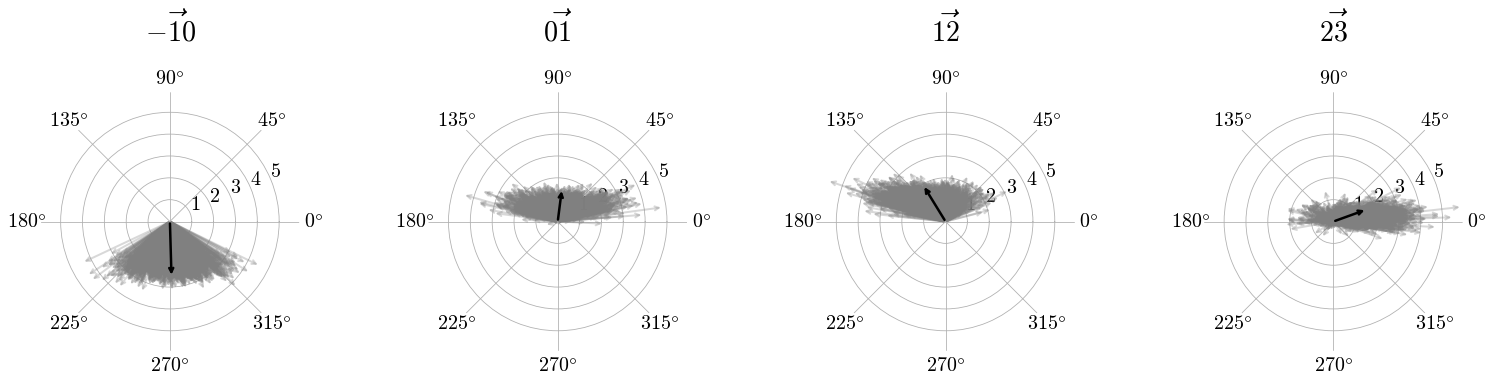

<Figure size 432x288 with 0 Axes>

In [9]:
fig,ax = plot_compass(av_polar_est_df)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'E2_evoked_theta_radius_raw.pdf'), dpi=1200, bbox_inches='tight', pad_inches=0) 

# Polar histograms ('rose plots')

<ipython-input-8-ec05831fb5f7>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(label)
<ipython-input-8-ec05831fb5f7>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(label)
<ipython-input-8-ec05831fb5f7>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(label)
<ipython-input-8-ec05831fb5f7>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(label)


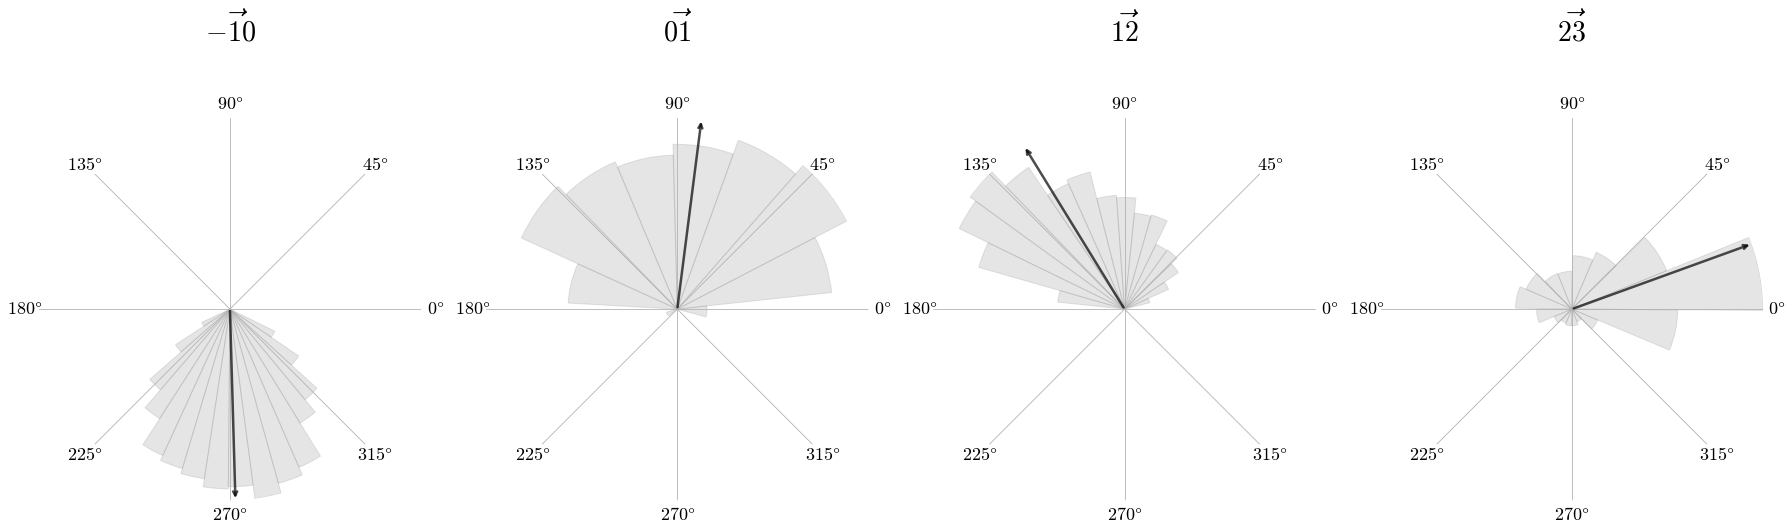

In [10]:
fig,ax = plot_roses(av_polar_est_df)
plt.tight_layout()

plt.savefig(os.path.join(fig_dir, 'E2_evoked_roses.pdf'), dpi=1200, bbox_inches='tight', pad_inches=0)